In [1]:
import numpy as np
import pandas as pd

from typing import List
from datetime import datetime, UTC
from sklearn.model_selection import ParameterGrid

from fractal.loaders import PriceHistory, RateHistory
from fractal.loaders import HyperliquidFundingRatesLoader, HyperLiquidPerpsPricesLoader

from fractal.core.base import Observation
from fractal.core.pipeline import (
    DefaultPipeline, MLFlowConfig, ExperimentConfig)
from fractal.core.entities import UniswapV3LPGlobalState, HyperLiquidGlobalState

from fractal.strategies.hyperliquid_basis import HyperliquidBasis

%load_ext autoreload
%autoreload 2

from funding_rates_downloader import get_binance_funding_rates, analyze_funding_rates, plot_funding_rates, get_hyperliquid_funding_rates

In [ ]:
def get_observations(
        rate_data: RateHistory, price_data: PriceHistory,
        start_time: datetime = None, end_time: datetime = None
    ) -> List[Observation]:
    """
    Get observations from the pool and price data for the ManagedBasisStrategy.

    Returns:
        List[Observation]: The observation list for ManagedBasisStrategy.
    """
    observations_df: pd.DataFrame = price_data.join(rate_data)
    observations_df['rate'] = observations_df['rate'].fillna(0)
    observations_df = observations_df.loc[start_time:end_time]
    observations_df = observations_df.dropna()
    start_time = observations_df.index.min()
    if end_time is None:
        end_time = observations_df.index.max()
    observations_df = observations_df.sort_index()
    return [
        Observation(
            timestamp=timestamp,
            states={
                'SPOT': UniswapV3LPGlobalState(price=price, tvl=0, volume=0, fees=0, liquidity=0),  # we need only spot price
                'HEDGE': HyperLiquidGlobalState(mark_price=price, funding_rate=rate)
            }
        ) for timestamp, (price, rate) in observations_df.iterrows()
    ]


def build_observations(
        ticker: str, start_time: datetime = None, end_time: datetime = None,
    ) -> List[Observation]:
    """
    Build observations for the ManagedBasisStrategy from the given start and end time.
    """
    rate_data: RateHistory = HyperliquidFundingRatesLoader(
          ticker, start_time=start_time, end_time=end_time).read(with_run=True)
    prices: PriceHistory = HyperLiquidPerpsPricesLoader(
          ticker, interval='1h', start_time=start_time, end_time=end_time).read(with_run=True)
    return get_observations(rate_data, prices, start_time, end_time)


def build_grid():
    raw_grid = ParameterGrid({
        'MIN_LEVERAGE': np.arange(1, 12, 1).tolist(),
        'TARGET_LEVERAGE': np.arange(1, 12, 1).tolist(),
        'MAX_LEVERAGE': np.arange(1, 12, 1).tolist(),
        'INITIAL_BALANCE': [1_000_000]
    })

    valid_grid = [
        params for params in raw_grid
        if round(params['MIN_LEVERAGE'], 1) < round(params['TARGET_LEVERAGE'], 1) < round(params['MAX_LEVERAGE'], 1)
    ]
    return valid_grid


if __name__ == '__main__':
    # Strategy environment
    ticker: str = 'BTC'
    start_time = datetime(2025, 1, 1, tzinfo=UTC)
    end_time = datetime(2025, 3, 1, tzinfo=UTC)
    experiment_name = f'hl_basis_{ticker}_{start_time.strftime("%Y-%m-%d")}_{end_time.strftime("%Y-%m-%d")}'
    HyperliquidBasis.MAX_LEVERAGE = 45
    
    # Mlflow setup
    mlflow_config: MLFlowConfig = MLFlowConfig(
        mlflow_uri='http://127.0.01:8080',
        experiment_name=experiment_name,
    )

    # Load data and build observations
    observations = build_observations(ticker, start_time, end_time)
    assert len(observations) > 0

    # Experiment setup
    experiment_config: ExperimentConfig = ExperimentConfig(
        strategy_type=HyperliquidBasis,
        backtest_observations=observations,
        window_size=24,  # number of scenarios from history
        params_grid=build_grid(),
        debug=True,
    )

    # Run the DefualtPipeline
    pipeline: DefaultPipeline = DefaultPipeline(
        experiment_config=experiment_config,
        mlflow_config=mlflow_config
    )
    pipeline.run()


In [ ]:
df = get_hyperliquid_funding_rates()

df.head()

Plot saved as eth_funding_rates.png


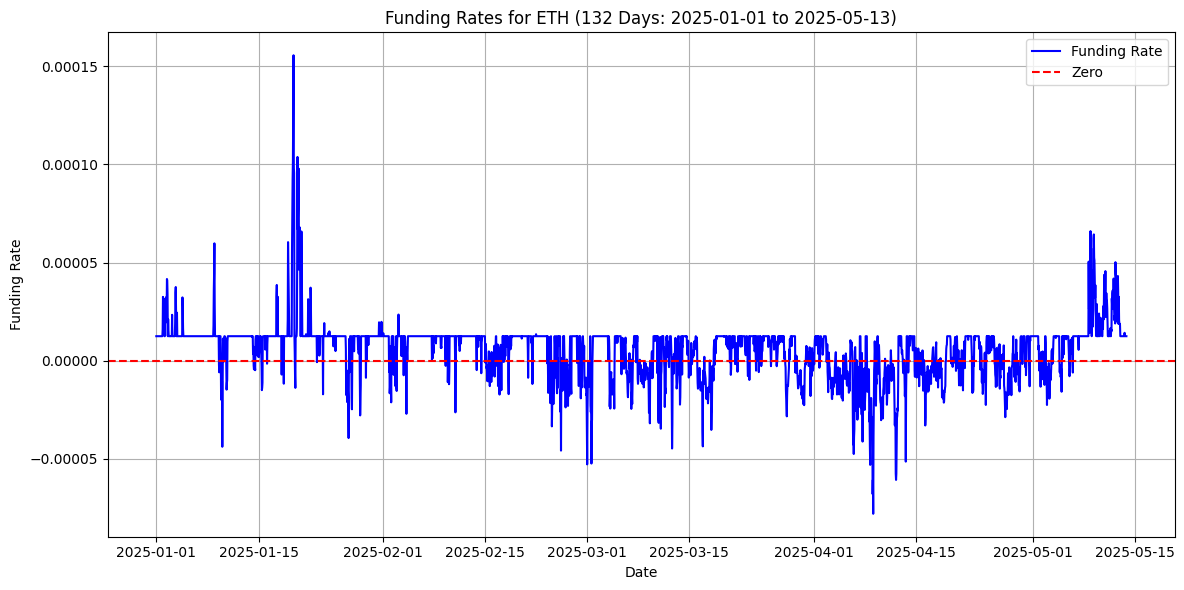

In [4]:
plot_funding_rates(df, 'ETH')

In [5]:
df

,fundingRate
time,
2025-01-01 00:00:00+00:00,0.000013
2025-01-01 01:00:00+00:00,0.000013
2025-01-01 02:00:00+00:00,0.000013
2025-01-01 03:00:00+00:00,0.000013
2025-01-01 04:00:00+00:00,0.000013
...,...
2025-05-13 16:00:00+00:00,0.000013
2025-05-13 17:00:00+00:00,0.000013
2025-05-13 18:00:00+00:00,0.000013
